In [4]:
# coding=utf-8
import torch.autograd
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import os
from torchvision.utils import make_grid

device ='cpu'
def to_img(x):
    # out = 0.5 * (x+0.5)
    out = x.clamp(0, 1)  # Clamp函数可以将随机变化的数值限制在一个给定的区间[min, max]内：
    out = out.view(-1, 1, 28, 28)  # view()函数作用是将一个多行的Tensor,拼接成一行
    return out

batch_size = 128
num_epoch = 1
z_dimension = 2
# 图形处理过程
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.repeat(3,1,1)),
])

# mnist dataset mnist数据集下载
mnist = datasets.MNIST(
    root='./data/', train=True, transform=img_transform, download=False
)

# data loader 数据载入
dataloader = torch.utils.data.DataLoader(
    dataset=mnist, batch_size=batch_size, shuffle=True
)


In [5]:
# 定义判别器  #####Discriminator######使用多层网络来作为判别器
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 定义编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
        )
        self.encoder_fc1=nn.Linear(32*7*7,z_dimension)
        self.encoder_fc2=nn.Linear(32*7*7,z_dimension)
        self.decoder_fc = nn.Linear(z_dimension,32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def noise_reparameterize(self,mean,logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x):
        out1,out2 = self.encoder(x),self.encoder(x)
        mean = self.encoder_fc1(out1.view(out1.shape[0],-1))
        logstd = self.encoder_fc2(out2.view(out2.shape[0],-1))
        z = self.noise_reparameterize(mean,logstd)
        out3 = self.decoder_fc(z)
        out3 = out3.view(out3.shape[0],32,7,7)
        out3 = self.decoder(out3)
        return out3,mean,logstd


torch.Size([12928, 40])
torch.Size([12928])


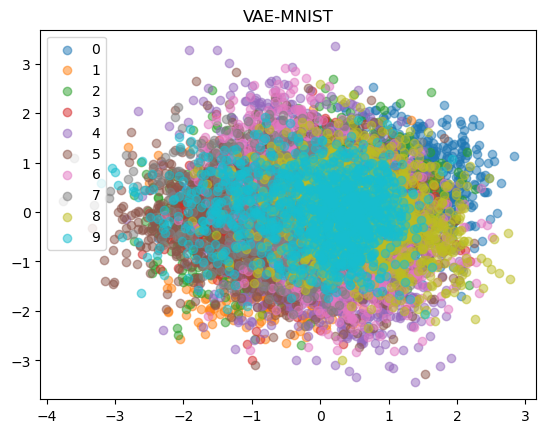

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 40x1568)

In [6]:

# 创建对象
vae = VAE().to(device)
vae.load_state_dict(torch.load('./VAE-40.pth'))
pos = []
label = []
###########################进入训练##判别器的判断过程#####################
for epoch in range(num_epoch):  # 进行多个epoch的训练
    for i, (img, lab) in enumerate(dataloader):
        num_img = img.size(0)
        # view()函数作用把img变成[batch_size,channel_size,784]
        img = img.view(num_img,  1,28,28).to(device)  # 将图片展开为28*28=784
        noise = torch.rand(img.shape).to(device)
        img = img+0.1*noise
        x,mean,logstd = vae(img)  # 将真实图片放入判别器中
        pos.append(mean)
        label.append(lab)
        if(i==100):
            break
pos = torch.cat(pos)
label = torch.cat(label)
print(pos.shape)
print(label.shape)
for i in range(10):
    plt.scatter(
        pos[label==i][:,0].detach().numpy(),
        pos[label==i][:,1].detach().numpy(),
        alpha=0.5,
        label=i)
plt.title('VAE-MNIST')
plt.legend()
plt.show()
import numpy as np
def plot_numbers(rangex,rangey):
    numbers = []
    x = torch.arange(rangex[0],rangex[1],0.5)
    y = torch.arange(rangey[0],rangey[1],0.5)
    for xx in x:
        for yy in y:
            z = torch.Tensor([[xx, yy]])
            out = vae.decoder_fc(z)
            out = out.view(out.shape[0], 32, 7, 7)
            decode = vae.decoder(out)
            numbers.append(decode)
    numbers = torch.cat(numbers)
    img = make_grid(numbers,nrow=len(x),normalize=True).detach().numpy()
    plt.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
    plt.show()
plot_numbers([-3,3],[-3,3])